In [144]:
import regex as re
import numpy as np

class LogLineProcessor:
    def __init__(self, regex_format):
        self.regex_format = regex_format

    def process_line(self, line):
        match = re.match(self.regex_format, line)
        if match:
            return match.group(1), match.group(2), match.group(3), match.group(4)
        else:
            return None

def process_adjsim_log(servers=None):
    log_processor = LogLineProcessor(r"INFO:root:([0-9]*\.[0-9]+|[0-9]+) - ([0-9]*\.[0-9]+|[0-9]+) - ([0-9]*\.[0-9]+|[0-9]+) - (arrival|departure)")

    count = 0
    max = 5000

    if servers is None:
        print("Please provide list of servers")
        return None

    queue_lengths = {}
    for server in servers:
        queue_lengths[int(server)] = 0

    result = []

    result.append([0 for i in range(len(servers))])

    previous_time = 0

    try:
        # Read the log file line by line
        with open("./logs/simulation.log", 'r') as f:
            for line in f:
                count += 1
                if count > max:
                    break
                processed_line = log_processor.process_line(line)
                if processed_line:
                    array1, array2, array3, array4 = processed_line
                    if array4 == 'arrival':
                        queue_lengths[int(array3)] += 1

                    elif array4 == 'departure':
                        queue_lengths[int(array3)] -= 1


                    if sum(queue_lengths.values()) > 0:
                        result.append([queue_lengths[int(server)] for server in servers])

    except:
        raise ValueError("Error in processing log file")
    
    return np.array(result)



In [254]:
dim = 20

import random

# create a random matrix of 10x10
matrix = np.random.rand(dim, dim)

servers = np.random.choice(range(dim), 14, replace=False)

distributions = []
for i in range(dim):
    distributions.append(['exponential',np.random.rand(),np.random.rand()])

queue_lengths = [330 for i in range(dim)]

# select sources as non-server nodes
sources = [i for i in range(dim) if i not in servers]

sinks = np.random.choice(servers, 2, replace=False)

# zero all elements in a row if the row index is a sink
for i in sinks:
    for j in range(dim):
        matrix[i][j] = 0

for i in sources:
    matrix[:, i] = 0
    matrix[i, i] = 0

for i in servers:
    matrix[i][i] = 0

# Add a small constant to the sum of each row to ensure it's never 0
row_sums = np.abs(matrix.sum(axis=1, keepdims=True)) + np.finfo(float).eps

# Normalize the matrix within float32 range
matrix = matrix / row_sums

matrix = np.round(matrix, 3)

# add difference between the sum of row and 1 to some random element in the row other than the diagonal element
for i in range(dim):
    matrix[i, i] = 0
    if i in servers and i not in sinks:
        matrix[i, np.random.choice([x for x in range(dim) if x != i]) ] += 1 - matrix[i].sum()


# Set the diagonal elements
for i in sources:
    matrix[i, i] = 1.0
for i in sinks:
    matrix[i, i] = -1.0
for i in [x for x in range(dim) if x not in sources]:
    matrix[i, i] = -1.0


np.random.seed(np.random.randint(0, 99999, size=1))
seeds = np.random.randint(0, 99999, size=1)

from simulation_v3 import Sim

sim = Sim(matrix, distributions, queue_lengths, seeds=seeds, log_path="logs/", generate_log=True,
            animation=False, record_history=False, logging_mode='Music')

sim.run(500)

# cut off first 1000 entries
result = process_adjsim_log(servers)[50:150]

print(result)

[[15  7  0 ...  0  0  0]
 [15  8  0 ...  0  0  0]
 [15  8  0 ...  0  0  0]
 ...
 [34  7  0 ...  1  1  1]
 [34  7  0 ...  1  1  1]
 [34  7  0 ...  1  1  1]]


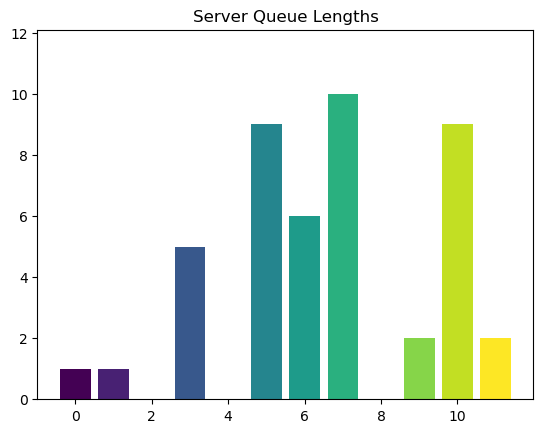

In [178]:
# create a video of the simulation in result as a bar graph with the x-axis as the servers and the y-axis as the queue length
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

fig, ax = plt.subplots()

x = np.arange(len(servers))
y = result[0]

# Generate a color for each server
colors = plt.cm.viridis(np.linspace(0, 1, len(servers)))

bar = ax.bar(x, y, color=colors)

# Set the title
ax.set_title('Server Queue Lengths')

ax.set_ylim(0, max(y)*1.1)

def animate(i):
    y = result[i]
    for i, b in enumerate(bar):
        b.set_height(y[i])
    ax.set_ylim(0, max(max(y)*1.1, ax.get_ylim()[1]))
    return bar

ani = animation.FuncAnimation(fig, animate, frames=len(result), repeat=False)

ani.save('simulation.gif', writer='pillow')


In [204]:
print(matrix)

[[-1.          0.02058307  0.          0.01140236  0.04473233  0.
   0.03357365  0.1306109   0.          0.          0.18148296  0.
   0.04245476  0.11908464  0.          0.20799515  0.12199821  0.
   0.          0.08608196]
 [ 0.14931771 -1.          0.          0.10282668  0.12816321  0.
   0.02710738  0.10675205  0.          0.          0.1020788   0.
   0.06485497  0.05044576  0.          0.13881077  0.10508903  0.
   0.          0.02455364]
 [ 0.04504348  0.06357552  1.          0.1343352   0.13828416  0.
   0.13972121  0.00423095  0.          0.          0.01310003  0.
   0.00622786  0.13938034  0.          0.09692478  0.1021787   0.
   0.          0.11699777]
 [ 0.08488556  0.0982608   0.         -1.          0.01897218  0.
   0.05179506  0.06103542  0.          0.          0.10212141  0.
   0.03652409  0.15689247  0.          0.16842675  0.07771837  0.
   0.          0.14336789]
 [ 0.10626254  0.00915492  0.          0.00463718 -1.          0.
   0.10846188  0.11629927  0.     

C:\Users\Sadie\AppData\Local\Temp\ipykernel_11972\3805099036.py:49: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  plt.colorbar(label='Matrix Values', cmap=cmap)


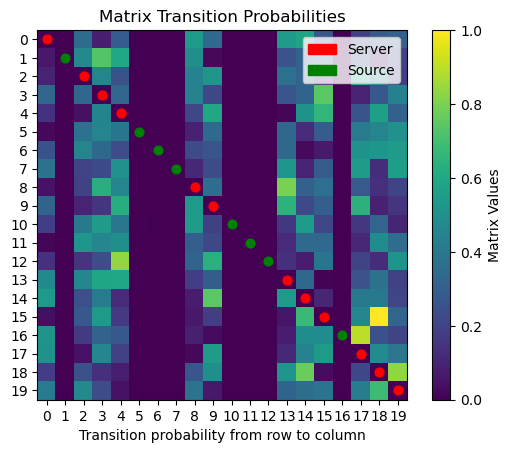

In [239]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import PowerNorm
import matplotlib.patches as mpatches

# Assume 'matrix' is your n x n matrix
n = len(matrix)

# Create a copy of the matrix and set the diagonal elements to NaN
matrix_copy = matrix.copy()

for i in range(n):
    matrix_copy[i, i] = 0


# Create a color map suitable for probability data
cmap = plt.get_cmap('viridis')

# Create the graph
plt.imshow(matrix_copy, cmap=cmap)

# Overlay a scatter plot on the heatmap to change the color of the diagonal elements
for i in range(n):
    if i in sources:
        plt.scatter(i, i, color='green', s=40)  # Green for sources
    if i in servers:
        plt.scatter(i, i, color='red', s=40)  # Red for servers

# Create custom legend entries
red_patch = mpatches.Patch(color='red', label='Server')
green_patch = mpatches.Patch(color='green', label='Source')

# Add the legend to the plot
plt.legend(handles=[red_patch, green_patch])

# Add a title
plt.title('Matrix Transition Probabilities')

# Set x-axis ticks at every integer value
plt.xticks(np.arange(n))

# Set y-axis ticks at every integer value
plt.yticks(np.arange(n))

# Add labels to the x and y axes
plt.xlabel('Transition probability from row to column')

# Add a colorbar indicating the scale of the heatmap values
plt.colorbar(label='Matrix Values', cmap=cmap)

# Display the graph
plt.show()

C:\Users\Sadie\AppData\Local\Temp\ipykernel_11972\2536424633.py:52: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  plt.colorbar(im, label='Matrix Values', cmap=cmap)


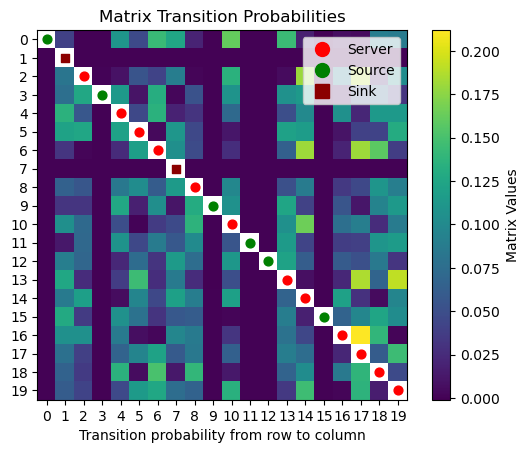

In [267]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# Assume 'matrix' is your n x n matrix
n = len(matrix)

# Create a copy of the matrix and set the diagonal elements to NaN
matrix_copy = matrix.copy()

for i in range(n):
    matrix_copy[i, i] = np.nan

# Create a color map suitable for probability data
cmap = plt.get_cmap('viridis')

# Create the graph
im = plt.imshow(matrix_copy, cmap=cmap, vmin=np.nanmin(matrix_copy), vmax=np.nanmax(matrix_copy))

# Overlay a scatter plot on the heatmap to change the color of the diagonal elements
for i in range(n):
    if i in sources:
        plt.scatter(i, i, color='green', s=40)  # Green for sources
    if i in servers and i not in sinks:
        plt.scatter(i, i, color='red', s=40)  # Red for servers
    if i in sinks:
        plt.scatter(i, i, marker='s', color='darkred', s=40)  # Orange square for sinks

# Create custom legend entries
red_line = mlines.Line2D([], [], color='red', marker='o', markersize=10, label='Server', linestyle='None')
orange_line = mlines.Line2D([], [], color='darkred', marker='s', markersize=10, label='Sink', linestyle='None')
green_line = mlines.Line2D([], [], color='green', marker='o', markersize=10, label='Source', linestyle='None')


# Add the legend to the plot
plt.legend(handles=[red_line, green_line, orange_line])

# Add a title
plt.title('Matrix Transition Probabilities')

# Set x-axis ticks at every integer value
plt.xticks(np.arange(n))

# Set y-axis ticks at every integer value
plt.yticks(np.arange(n))

# Add labels to the x and y axes
plt.xlabel('Transition probability from row to column')

# Add a colorbar indicating the scale of the heatmap values
plt.colorbar(im, label='Matrix Values', cmap=cmap)

# Display the graph
plt.show()